In [ ]:
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Libraries Import

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


In [4]:
# Load the dataset
train_images = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/Project/datasets/k49-train-imgs.npz')['arr_0']
train_labels = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/Project/datasets/k49-train-labels.npz')['arr_0']
test_images = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/Project/datasets/k49-test-imgs.npz')['arr_0']
test_labels = np.load('C:/Users/rosmi/OneDrive/Desktop/Probs Model n Inference/Project/datasets/k49-test-labels.npz')['arr_0']


In [5]:

# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define a function for one-hot encoding using PyTorch
def to_one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]

# Convert labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# One-hot encode the labels
num_classes = 49
train_labels_onehot = to_one_hot(train_labels_tensor, num_classes)
test_labels_onehot = to_one_hot(test_labels_tensor, num_classes)

# Convert images to PyTorch tensors and add a channel dimension
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

# Create TensorDataset and DataLoader

train_dataset = TensorDataset(train_images_tensor, train_labels_onehot)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_onehot)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [6]:

# Define the C-VAE model
class CVAE(nn.Module):
    def __init__(self, image_size, label_size, hidden_dim, latent_dim):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(image_size + label_size, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim + label_size, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, image_size)
    
    def encode(self, x, c):
        h = F.relu(self.fc1(torch.cat([x, c], dim=1)))
        return self.fc2_mean(h), self.fc2_logvar(h)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def decode(self, z, c):
        h = F.relu(self.fc3(torch.cat([z, c], dim=1)))
        return torch.sigmoid(self.fc4(h))
    
    def forward(self, x, c):
        mean, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparameterize(mean, logvar)
        return self.decode(z, c), mean, logvar

# Create an instance of the C-VAE model
image_size = 28 * 28  # 28x28 images
label_size = 49  # 49 classes
hidden_dim = 256
latent_dim = 64
cvae = CVAE(image_size, label_size, hidden_dim, latent_dim)


In [10]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cvae.to(device)

# Define the loss function
def loss_function(recon_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return BCE + KLD

optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
# Training loop with batching and GPU utilization
num_epochs = 40
for epoch in range(num_epochs):
    cvae.train()
    train_loss = 0
    for batch_idx, (img, lbl) in enumerate(train_loader):
        img = img.view(-1, 28*28).to(device)
        lbl = lbl.to(device)
        
        optimizer.zero_grad()
        recon_batch, mean, logvar = cvae(img, lbl)
        loss = loss_function(recon_batch, img, mean, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 1, Loss: 176.7678120477885
Epoch 2, Loss: 176.51697227296293
Epoch 3, Loss: 176.33677118720144
Epoch 4, Loss: 176.14994233462843
Epoch 5, Loss: 175.99693103051771
Epoch 6, Loss: 175.86768389457993
Epoch 7, Loss: 175.7128473076773
Epoch 8, Loss: 175.6117209143952
Epoch 9, Loss: 175.48108021685644
Epoch 10, Loss: 175.38313406608407
Epoch 11, Loss: 175.32293828119955
Epoch 12, Loss: 175.23331557898874
Epoch 13, Loss: 175.17244780403405
Epoch 14, Loss: 175.09704658820712
Epoch 15, Loss: 175.04931509920746
Epoch 16, Loss: 174.9898151631727
Epoch 17, Loss: 174.93430103021848
Epoch 18, Loss: 174.84566460296838
Epoch 19, Loss: 174.82053166707686
Epoch 20, Loss: 174.76781480896838
Epoch 21, Loss: 174.72001773879458
Epoch 22, Loss: 174.66653451247902
Epoch 23, Loss: 174.61132862302102
Epoch 24, Loss: 174.5736033851309
Epoch 25, Loss: 174.5317962954464
Epoch 26, Loss: 174.49835751824313
Epoch 27, Loss: 174.45322769319685
Epoch 28, Loss: 174.41912866829261
Epoch 29, Loss: 174.3820009253525
E

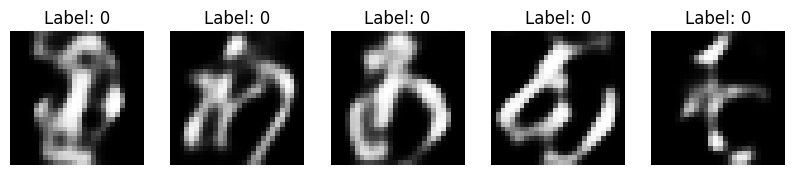

In [11]:


# Function to generate new images and show the class label
def generate_and_show_images(cvae, num_samples, label):
    cvae.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        labels = torch.eye(num_classes)[torch.tensor([label] * num_samples)].to(device)
        generated_images = cvae.decode(z, labels).view(-1, 1, 28, 28).cpu()
    
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(generated_images[i, 0, :, :], cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Generate and show 5 new images for a specific class (e.g., class 0)
generate_and_show_images(cvae, num_samples=5, label=0)


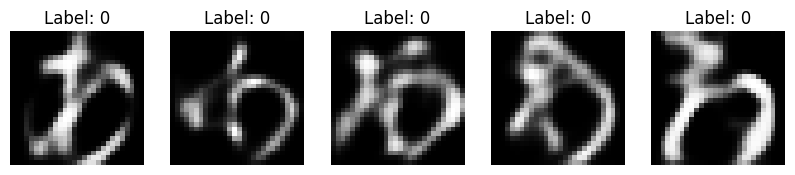

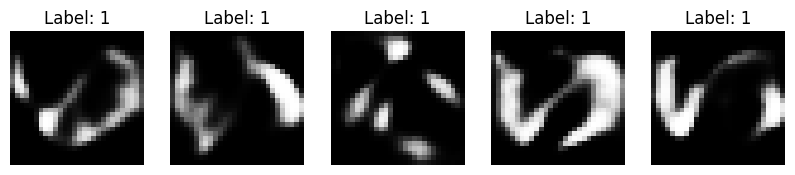

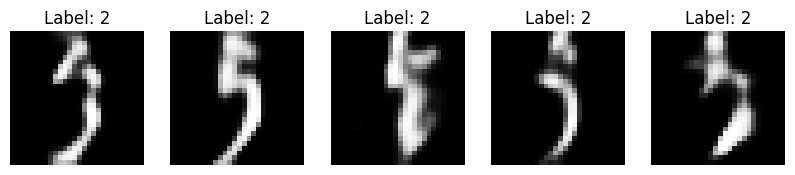

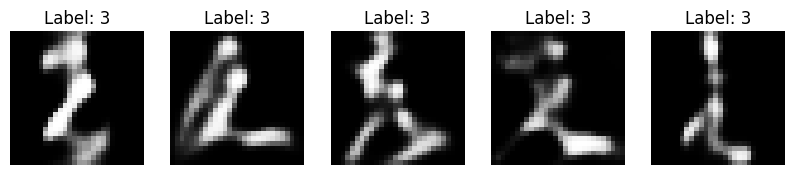

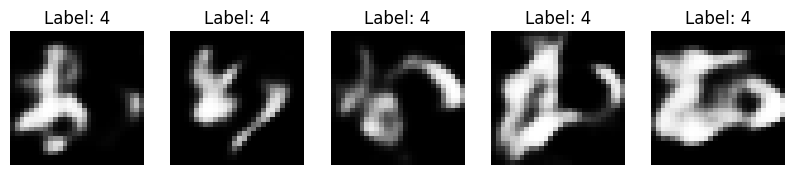

In [12]:
# Generate and show images for multiple classes
for label in range(5):  # Change range to generate for more labels
    generate_and_show_images(cvae, num_samples=5, label=label)


CGAN

In [1]:


class CGANGenerator(nn.Module):
    def __init__(self, z_dim, label_dim, img_dim):
        super(CGANGenerator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim + label_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, momentum=0.8),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, momentum=0.8),
            nn.ReLU(),
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        img = self.model(x)
        img = img.view(img.size(0), 1, 28, 28)
        return img


In [2]:
class CGANDiscriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(CGANDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        c = self.label_emb(labels)
        x = torch.cat([img_flat, c], 1)
        validity = self.model(x)
        return validity


In [8]:
pip install pandoc

You should consider upgrading via the 'C:\Users\rosmi\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:


# Normalize the images to the range [0, 1]
train_images = train_images / 255.0
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1, 28, 28)
train_labels = torch.tensor(train_labels, dtype=torch.long)

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(train_images, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Hyperparameters
z_dim = 100
label_dim = 49
img_dim = 28 * 28
lr = 0.0002

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Model instantiation
generator = CGANGenerator(z_dim, label_dim, img_dim).to(device)
discriminator = CGANDiscriminator(img_dim, label_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
adversarial_loss = nn.BCELoss()

In [7]:
num_epochs = 10
for epoch in range(num_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.size(0)
        
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # Labels for real and fake images
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Generate fake images
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, label_dim, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)
        
        # Real loss
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        # Fake loss
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        # Total loss
        d_loss = real_loss + fake_loss
        
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        
        g_loss.backward()
        optimizer_G.step()
        
    print(f"Epoch [{epoch}/{num_epochs}] | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

Epoch [0/10] | D Loss: 0.9015692472457886 | G Loss: 1.9576539993286133
Epoch [1/10] | D Loss: 0.8211238980293274 | G Loss: 2.0626869201660156
Epoch [2/10] | D Loss: 0.6699961423873901 | G Loss: 2.801133394241333
Epoch [3/10] | D Loss: 0.5795276165008545 | G Loss: 3.9844069480895996
Epoch [4/10] | D Loss: 0.45219576358795166 | G Loss: 2.496548891067505
Epoch [5/10] | D Loss: 0.40856117010116577 | G Loss: 3.119898796081543
Epoch [6/10] | D Loss: 0.6129084825515747 | G Loss: 2.7360942363739014
Epoch [7/10] | D Loss: 0.3954985737800598 | G Loss: 3.745521068572998
Epoch [8/10] | D Loss: 0.41457656025886536 | G Loss: 3.344794750213623
Epoch [9/10] | D Loss: 0.2834777534008026 | G Loss: 4.072869777679443


In [ ]:
def generate_images(generator, num_samples, label, z_dim=100):
    z = torch.randn(num_samples, z_dim).to(device)
    labels = torch.tensor([label] * num_samples).to(device)
    with torch.no_grad():
        generated_imgs = generator(z, labels)
    return generated_imgs

def show_generated_images(images, num_images, label):
    images = images.cpu().numpy()
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {label}")
    plt.show()

# Generate and display images
for label in range(5):  # Adjust range for more labels
    generated_imgs = generate_images(generator, num_samples=5, label=label)
    show_generated_images(generated_imgs, num_images=5, label=label)